<a href="https://colab.research.google.com/github/shreyus3003/GenAI/blob/main/Stable%20diffusion/Stable_Diffusion_Part_3_Fine_tuning_darshan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning with Dreambooth








## Installing the libraries

In [1]:
!pip install torch==2.1.0+cu121 torchvision==0.16.0+cu121 torchaudio==2.1.0 torchtext==0.16.0+cpu torchdata==0.7.0 --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 47.4 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.16.0
    Uninstalling torchtext-0.16.0:
      Successfully uninstalled torchtext-0.16.0


In [2]:
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py
%pip install -qq git+https://github.com/ShivamShrirao/diffusers
%pip install -q -U --pre triton
%pip install -q accelerate transformers ftfy bitsandbytes gradio natsort safetensors xformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 MB 10.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.1.0+cu121 requires triton==2.1.0, but you have triton 2.2.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.2/218.2 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup

## Loading the model


> Terms of use

* https://huggingface.co/spaces/CompVis/stable-diffusion-license


In [3]:
model_sd = "runwayml/stable-diffusion-v1-5"
# model_sd = "runwayml/stable-diffusion-v1-5"
output_dir = "/content/stable_diffusion_weights/zwx"

In [4]:
!mkdir -p $output_dir

## Training

Three components are needed:
1. unique identifier
2. class name
3. images

Instance prompt
a photo of [unique identifier] [class name]

Class prompt
> a photo of [class name]

The instance prompt will be as follows:
> a photo of zwx person

As the subject is a person, the class prompt will be as follows:
> a photo of a person

In [10]:
concepts_list = [
    {
        "instance_prompt": "zwx",
        "class_prompt": "photo of a person",
        "instance_data_dir": "/content/data/zwx",
        "class_data_dir": "/content/data/person"

    }
]

In [11]:
import json
import os
import random

for c in concepts_list:
  os.makedirs(c["instance_data_dir"], exist_ok=True)

In [13]:
with open("concepts_list.json", "w") as f:
  json.dump(concepts_list, f, indent=4)

### Parameters

In [14]:
num_imgs = 10
num_class_images = num_imgs * 12
max_num_steps = num_imgs * 80
learning_rate = 1e-6 # 0.0000001
lr_warmup_steps = int(max_num_steps / 10)
print(num_imgs, num_class_images, max_num_steps, learning_rate, lr_warmup_steps)

10 120 800 1e-06 80


In [15]:
!python3 train_dreambooth.py \
  --pretrained_model_name_or_path=$model_sd \
  --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
  --output_dir=$output_dir \
  --revision="fp16" \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=777 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=$learning_rate \
  --lr_scheduler="constant" \
  --lr_warmup_steps=80 \
  --num_class_images=$num_class_images \
  --sample_batch_size=4 \
  --max_train_steps=$max_num_steps \
  --save_interval=10000 \
  --save_sample_prompt="zwx" \
  --concepts_list="concepts_list.json"

2024-02-25 19:12:24.010316: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 19:12:24.010392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 19:12:24.011815: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-25 19:12:25.049075: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you do

In [16]:
from natsort import natsorted
from glob import glob
import os

weights_dir = natsorted(glob(output_dir + os.sep + '*'))[-1]
print('Weights directory: ', weights_dir)

Weights directory:  /content/stable_diffusion_weights/zwx/800


In [17]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def grid_img(imgs, rows=1, cols=3, scale=1):
  assert len(imgs) == rows * cols

  w, h = imgs[0].size
  w, h = int(w*scale), int(h*scale)

  grid = Image.new('RGB', size=(cols*w, rows*h))
  grid_w, grid_h = grid.size

  for i, img in enumerate(imgs):
      img = img.resize((w,h), Image.ANTIALIAS)
      grid.paste(img, box=(i%cols*w, i//cols*h))
  return grid

<ipython-input-17-61ea6e59baf2>:15: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((w,h), Image.ANTIALIAS)


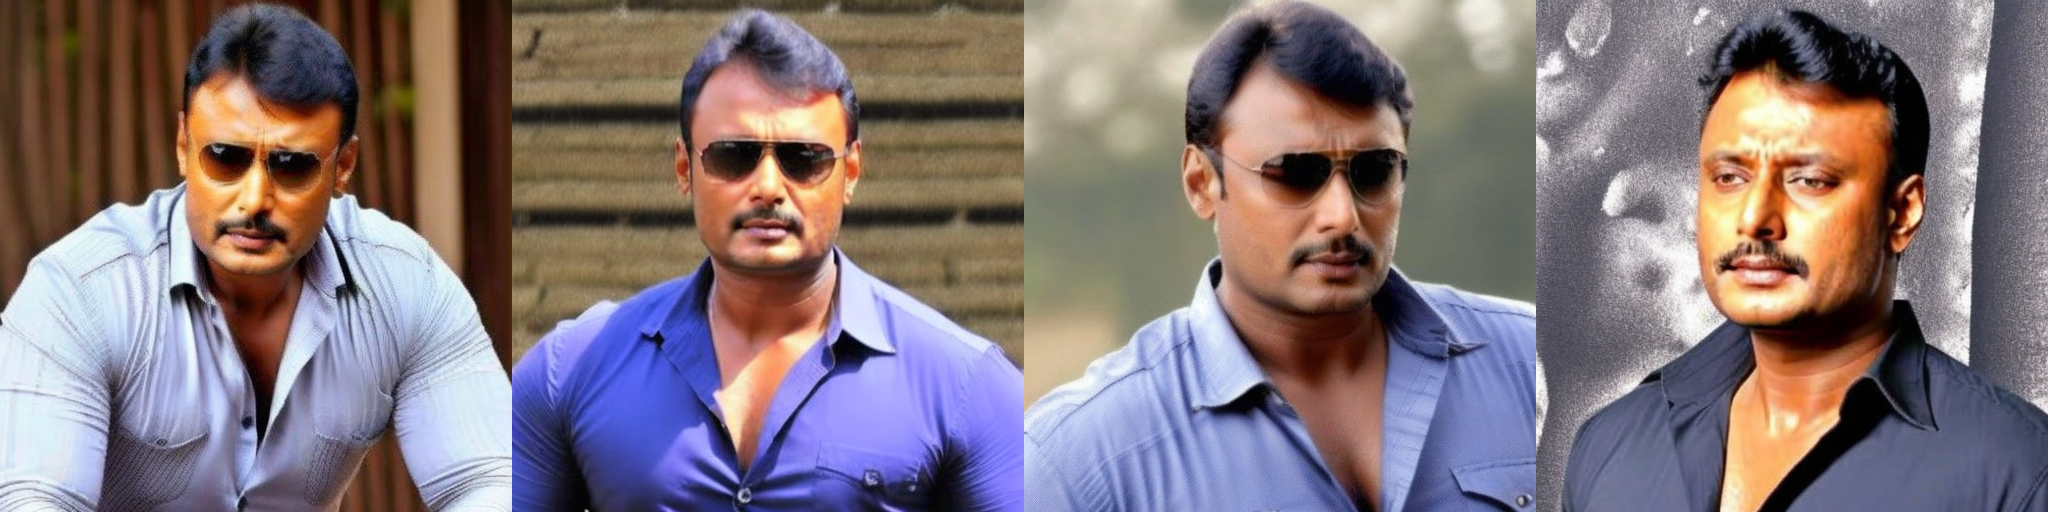

In [18]:
weights_folder = output_dir
folders = sorted([f for f in os.listdir(weights_folder) if f != "0"], key = lambda x: int(x))

imgs_test = []

for imgs, folder in enumerate(folders):
  folder_path = os.path.join(weights_folder, folder)
  image_folder = os.path.join(folder_path, "samples")
  images = [f for f in os.listdir(image_folder)]

  for i in images:
    img_path = os.path.join(image_folder, i)
    r = Image.open(img_path)
    imgs_test.append(r)

grid_img(imgs_test, rows=1, cols=4, scale=1)

## Convert the weights into (checkpoint)

In [19]:
ckpt_path = weights_dir + "/model.ckpt"

half_arg = "--half" # fp16

!python convert_diffusers_to_original_stable_diffusion.py --model_path $weights_dir  --checkpoint_path $ckpt_path $half_arg
print(f"Converted to ckpt and saved in {ckpt_path}")

Reshaping encoder.mid.attn_1.q.weight for SD format
Reshaping encoder.mid.attn_1.k.weight for SD format
Reshaping encoder.mid.attn_1.v.weight for SD format
Reshaping encoder.mid.attn_1.proj_out.weight for SD format
Reshaping decoder.mid.attn_1.q.weight for SD format
Reshaping decoder.mid.attn_1.k.weight for SD format
Reshaping decoder.mid.attn_1.v.weight for SD format
Reshaping decoder.mid.attn_1.proj_out.weight for SD format
Converted to ckpt and saved in /content/stable_diffusion_weights/zwx/800/model.ckpt


## Inference (tests)

In [20]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display

In [21]:
model_path = weights_dir
print(model_path)

/content/stable_diffusion_weights/zwx/800


In [22]:
pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16).to('cuda')

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [23]:
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()
seed = 777

## Generating images

Seed: 589717246


  0%|          | 0/30 [00:00<?, ?it/s]

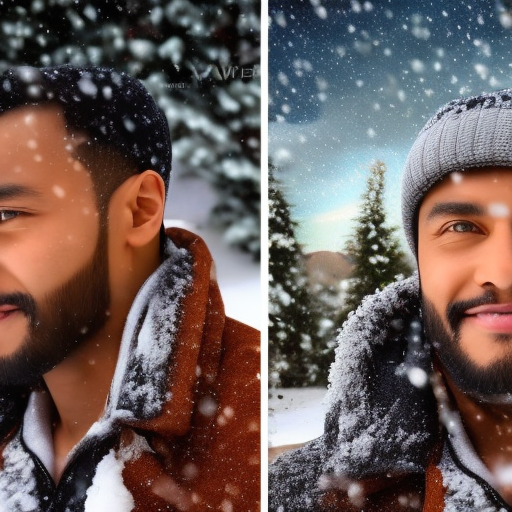

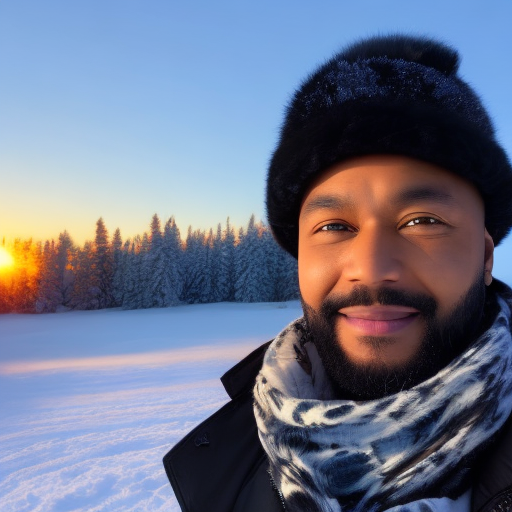

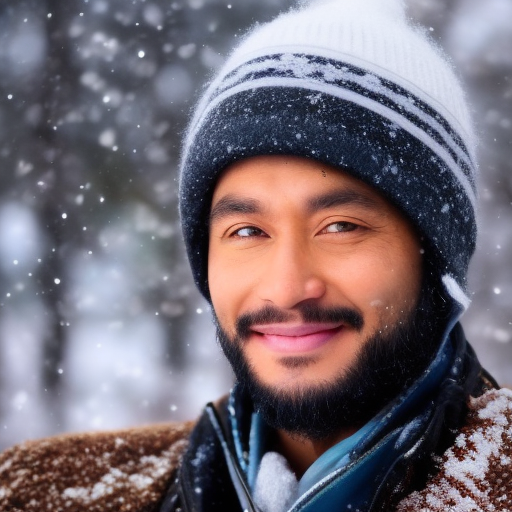

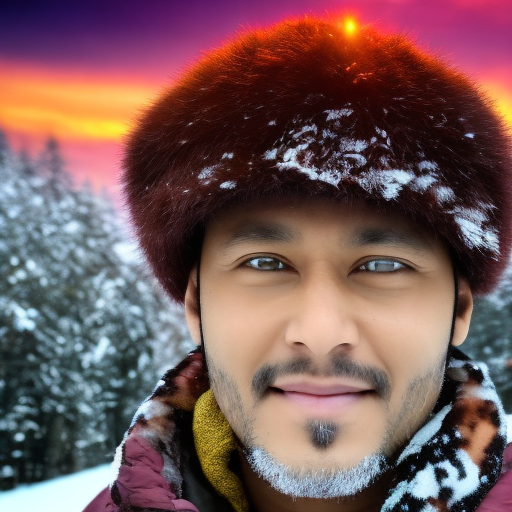

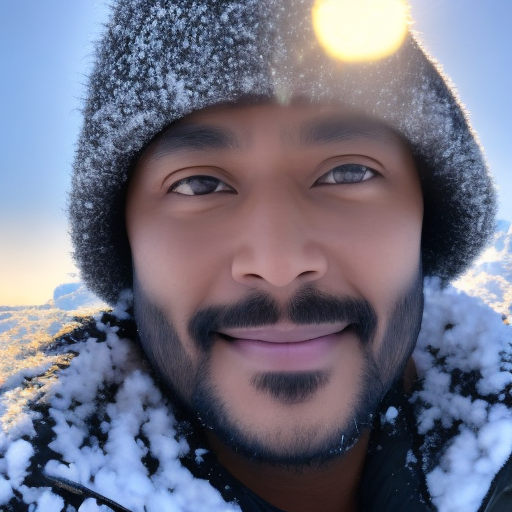

In [24]:
prompt = "face portrait of zwx in the snow, realistic, hd, vivid, sunset"
negative_prompt = "bad anatomy, ugly, deformed, desfigured, distorted face, poorly drawn hands, poorly drawn face, poorly drawn feet, blurry, low quality, low definition, lowres, out of frame, out of image, cropped, cut off, signature, watermark"
num_samples = 5
guidance_scale = 7.5
num_inference_steps = 30
height = 512
width = 512

seed = random.randint(0, 2147483647)
print("Seed: {}".format(str(seed)))
generator = torch.Generator(device='cuda').manual_seed(seed)

with autocast("cuda"), torch.inference_mode():
    imgs = pipe(
        prompt,
        negative_prompt=negative_prompt,
        height=height, width=width,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=generator
    ).images

for img in imgs:
    display(img)

### Testing multiple prompts

Seed: 591094325


  0%|          | 0/30 [00:00<?, ?it/s]

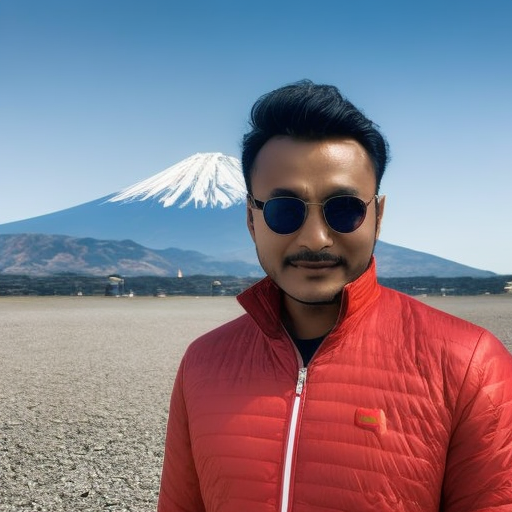

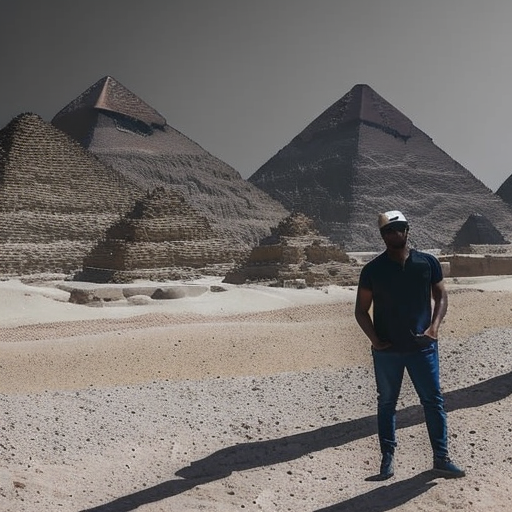

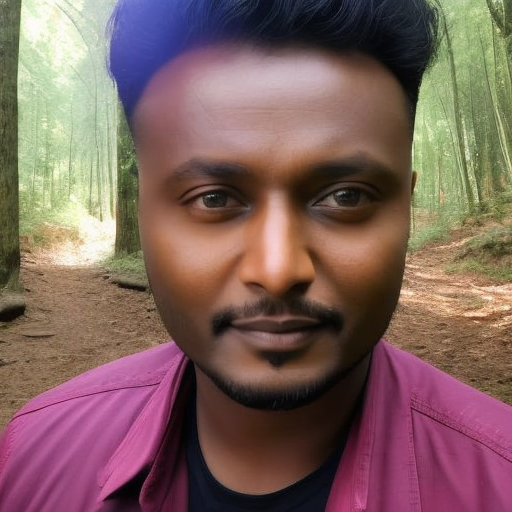

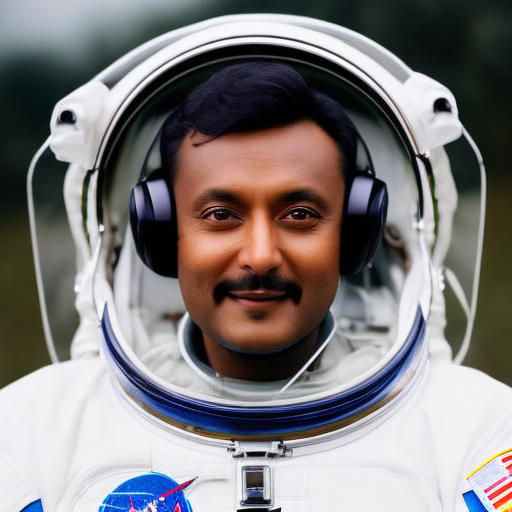

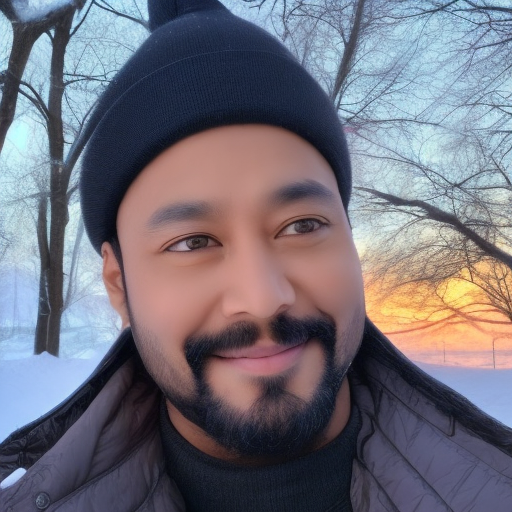

In [25]:
prompt = ["photo of zwx person, closeup, mountain fuji in the background, natural lighting",
          "photo of zwx person in the desert, closeup, pyramids in the background, natural lighting, frontal face",
          "photo of zwx person in the forest, natural lighting, frontal face",
          "photo of zwx person as an astronaut, natural lighting, frontal face, closeup, starry sky in the background",
          "face portrait of zwx in the snow, realistic, hd, vivid, sunset"]

negative_prompt = ["bad anatomy, ugly, deformed, desfigured, distorted face, poorly drawn hands, poorly drawn face, poorly drawn feet, blurry, low quality, low definition, lowres, out of frame, out of image, cropped, cut off, signature, watermark" ] * len(prompt)
num_samples = 1
guidance_scale = 7.5
num_inference_steps = 30
height = 512
width = 512

seed = random.randint(0, 2147483647) # random value
print("Seed: {}".format(str(seed)))
generator = torch.Generator(device='cuda').manual_seed(seed)

with autocast("cuda"), torch.inference_mode():
    imgs = pipe(
        prompt,
        negative_prompt=negative_prompt,
        height=height, width=width,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=generator
    ).images

for img in imgs:
    display(img)

### More prompt examples

* in the forest, in cairo, in cairo desert,  in a western scene, in star wars, in mountain fuji, in the snow, etc.

> Other combinations:

* `photo of zwx person, closeup, mountain fuji in the background, natural lighting `

* `digital painting of zwx in the snow, realistic, hd, vivid, sunset`

* `watercolor painting of zwx person, realistic, blue and orange tones `

* `digital painting of zwx person, hyperrealistic, fantasy, Surrealist, painted by Alphonse Mucha`

* `painting of zwx person in star wars, realistic, 4k ultra hd, blue and red tones`

* `photo of zwx person, in an armor, realistic, visible face, colored, detailed face, ultra detailed, natural lighting`

* `photo of zwx person, cyberpunk, vivid, realistic, 4k ultra hd`

* `anime painting of zwx person, chill day, by tim okamura, noah bradley, trending on artstation  `

## Saving the results

In [ ]:
!mkdir results

In [ ]:
for i, img in enumerate(imgs):
  img.save('results/result_{}.png'.format(i+1))

> More information about this Dreambooth implementation:
https://github.com/ShivamShrirao/diffusers/tree/main/examples/dreambooth